# Test point-based registration

In [1]:
%matplotlib widget
import numpy as np
import os
import open3d as o3d
import copy
import time
import matplotlib.pyplot as plt

import planeslam.io as io

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Open3D ICP registration

In [4]:
# Visualization helper
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [5]:
# Initialize source and target
def initalize_source_and_target(source_data, target_data):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_data)
    source.estimate_normals()
    source.orient_normals_towards_camera_location()

    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_data)
    target.estimate_normals()
    target.orient_normals_towards_camera_location()

    return source, target

source, target = initalize_source_and_target(PC_data[0], PC_data[1])

In [6]:
# Visualize
o3d.visualization.draw_geometries([target])

In [7]:
# Initial guess transform 
trans_init = np.eye(4)
threshold = 0.02

evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

RegistrationResult with fitness=4.595588e-04, inlier_rmse=1.658737e-02, and correspondence_set size of 3
Access transformation to get result.


In [8]:
# Fast Global Registration with RANSAC for initial transform
def execute_fast_global_registration(source, target , source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [9]:
# Point-to-point ICP
print("Apply point-to-point ICP")

def p2p_ICP(source, target, threshold, trans_init):
    start_time = time.time()
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    eval_time = time.time() - start_time
    return reg_p2p, eval_time

reg_p2p, eval_time = p2p_ICP(source, target, threshold, trans_init)
print("Elapased time: ", eval_time)
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
Elapased time:  0.019012451171875
RegistrationResult with fitness=6.280637e-03, inlier_rmse=1.329315e-02, and correspondence_set size of 41
Access transformation to get result.
Transformation is:
[[ 9.62607006e-01  7.05381633e-05  2.70901728e-01 -9.08054546e-01]
 [-1.56330597e-04  9.99999944e-01  2.95113544e-04 -6.75400308e-03]
 [-2.70901692e-01 -3.26428594e-04  9.62606964e-01 -4.43856240e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Full Trajectory Open3D ICP registration

In [10]:
# Full Trajectory Point-to-point ICP
def full_trajectory_p2p_ICP(trajectory, threshold = 1, init_w_RANSAC = False, print_results = False, plot_results = False):
    # Initialize vectors to store the results and evaluation times
    traj_reg_p2p = []
    traj_eval_time = []

    # Loop through the trajectory staring with the 2nd point cloud
    for i in range(1, len(trajectory)):
        # Initialize the source and target point clouds
        source, target = initalize_source_and_target(trajectory[i-1], trajectory[i])

        # Define the threshold and initial transform
        if init_w_RANSAC:
            trans_init = np.eye(4)
        else:
            trans_init = np.eye(4)

        reg_p2p, eval_time = p2p_ICP(source, target, threshold, trans_init)
        traj_reg_p2p.append(reg_p2p)
        traj_eval_time.append(eval_time)

        if print_results:
            print("Elapased time: ", eval_time)
            print(reg_p2p)

        if plot_results:
            draw_registration_result(source, target, reg_p2p.transformation)

    return traj_reg_p2p, traj_eval_time 

traj_reg_p2p, traj_eval_time = full_trajectory_p2p_ICP(PC_data, print_results=False, plot_results=False)
traj_fitness = [reg_p2p.fitness for reg_p2p in traj_reg_p2p]
traj_inlier_rmse = [reg_p2p.inlier_rmse for reg_p2p in traj_reg_p2p]
traj_transformation = [reg_p2p.transformation for reg_p2p in traj_reg_p2p]

(0.0, 10.0)

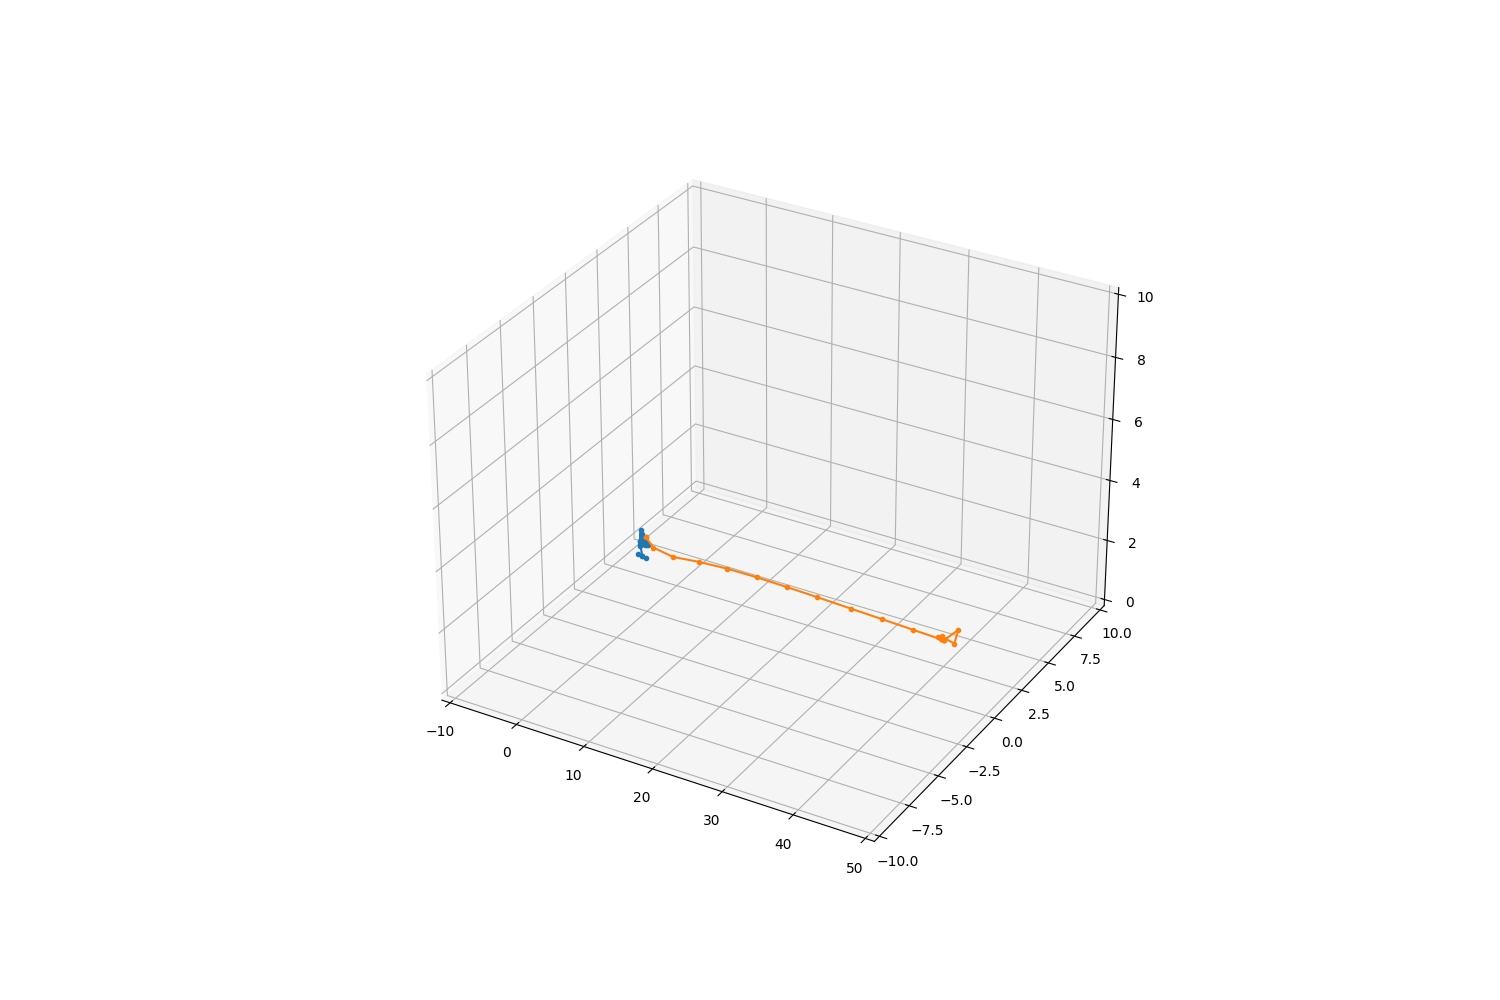

In [11]:
traj = [np.append(drone_positions[0], 1)]
for transformation in traj_transformation:
    traj.append(transformation @ traj[-1])

traj = np.array(traj)[:,:3]

# Plot the points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot3D(traj[:,0], traj[:,1], -traj[:,2], marker='.') 
ax.plot3D(drone_positions[:,0], drone_positions[:,1], -drone_positions[:,2], marker='.') 
ax.axes.set_xlim3d(left=-10, right=50) 
ax.axes.set_ylim3d(bottom=-10, top=10) 
ax.axes.set_zlim3d(bottom=0, top=10)

Open3D Demo

In [12]:
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])

np.asarray(source.normals)

array([[-0.62956297,  0.66870427, -0.39558202],
       [ 0.01322357,  0.06152465, -0.99801797],
       [ 0.01659746,  0.06297147, -0.99787724],
       ...,
       [-0.24384584, -0.52947396, -0.81252468],
       [-0.05902789, -0.70068824, -0.71102154],
       [-0.15078427, -0.55733532, -0.81648111]])

In [13]:
print("Apply point-to-plane ICP")
start_time = time.time()
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print("Elapased time: ", time.time() - start_time)
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
Elapased time:  11.81185269355774
RegistrationResult with fitness=5.391405e-02, inlier_rmse=1.175471e-02, and correspondence_set size of 10720
Access transformation to get result.
Transformation is:
[[ 9.99331534e-01  4.75860054e-04 -3.65548779e-02  8.43258075e-02]
 [-1.08268305e-03  9.99861918e-01 -1.65823278e-02  6.27310720e-02]
 [ 3.65419395e-02  1.66108204e-02  9.99194059e-01 -8.64498123e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
